In [1]:
from PIL import Image, ImageOps
import numpy as np
import math

None
(237, 270)
L


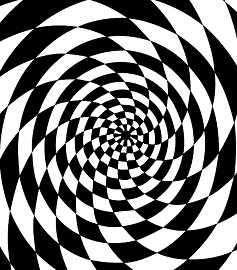

In [2]:
image = Image.open('op-art-black-and-white-infinity-whirl-tom-hill.jpg')
image = ImageOps.grayscale(image)
print(image.format)
print(image.size)
print(image.mode)
# show the image
data = np.asarray(image)
image

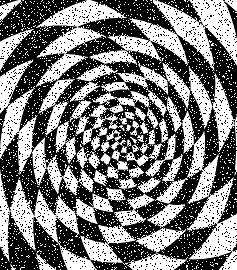

In [3]:
# Constantes

tau = 1.18
alpha = 0
beta = 0.3

def bruiteur(image, proba):
  image_array = data.astype('int16')
  image_array = image_array
  for i in range(np.shape(image_array)[0]):
    for j in range(np.shape(image_array)[1]):
      a = np.random.choice([-1, 1], None, p=[proba, 1-proba])
      if a < 0:
        image_array[i][j] = 255 - image_array[i][j]
  return image_array
bruit_test = bruiteur(image, 0.1) # Bruitage par inversion de 10 % des pixels
from matplotlib import cm
PIL_image = Image.fromarray(np.uint8(bruit_test)).convert('L')
PIL_image

In [4]:
print(bruit_test)
bruit_test_norm = 2*(bruit_test/255)-1 # yi € {-1 ; 1} (image bruitée, 1 = noir -1 = blanc), xi € {-1 ; 1} (image restaurée, 1 = noir -1 = blanc)

[[  0   1   1 ... 255 255 255]
 [254   3   0 ... 255 255 255]
 [  0   0   3 ... 255 255 255]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]]


In [ ]:
# Sampler de Gibbs (tau, alpha, beta connus)
# https://towardsdatascience.com/image-denoising-with-gibbs-sampling-mcmc-concepts-and-code-implementation-11d42a90e153

def debruiteur(img_bruitee, samples, alpha, beta, tau):
  probas = np.zeros(bruit_test_norm.shape)
  img_random = 2*np.random.randint(2, size=(270, 237))-1
  for step in range(samples):
          for i in range(1, img_random.shape[0]-1):
              for j in range(1, img_random.shape[1]-1):
                  y = sample_y(i, j, img_random, img_bruitee, alpha, beta, tau)
                  img_random[i, j] = y
                  if y == 1:
                      probas[i, j] += 1
  probas = probas / samples
  return probas

def sample_y(i, j, Y, X, alpha, beta, tau): #échantillon de P(x[i,j] | V(x[i,j])) (V[x[i,j]] contient les pixels adjacents à x[i,j], et contient y[i,j])
    markov_blanket = [Y[i - 1, j], Y[i, j - 1], Y[i, j + 1], Y[i + 1, j], X[i, j]]
    w = ((markov_blanket[-1]-1)**2)/(2*tau**2) - alpha + beta * sum(markov_blanket)
    w2 = ((markov_blanket[-1]+1)**2)/(2*tau**2) + alpha - beta * sum(markov_blanket)
    prob = np.exp(w)/(np.exp(w2) + np.exp(w))
    return (np.random.rand() < prob) * 2 - 1
  
probas = debruiteur(bruit_test_norm, 100, alpha, beta, tau)

In [ ]:
probas_copy = probas[:]

In [ ]:
probas_copy

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.81, 0.96, ..., 0.09, 0.52, 0.  ],
       [0.  , 0.73, 0.85, ..., 0.1 , 0.4 , 0.  ],
       ...,
       [0.  , 0.92, 0.88, ..., 0.1 , 0.13, 0.  ],
       [0.  , 0.97, 0.82, ..., 0.21, 0.07, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

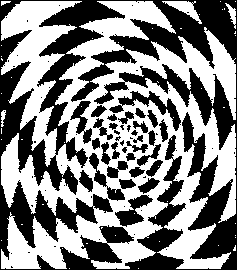

In [ ]:
probas_copy[probas_copy > 0.5] = 255
probas_copy[probas_copy <= 0.5] = 0
PIL_image2 = Image.fromarray(np.uint8(probas_copy)).convert('L')
PIL_image2

In [11]:
#Q2, a priori inverse-gamma (ne fonctionne pas)
param_alpha = 0
param_beta = 0.3
param_gamma = 0.3
param_latent_var = 1.18

def debruiteur2(img_bruitee, samples, alpha, beta, gamma, sigma):
  probas = np.zeros(bruit_test_norm.shape)
  img_random = 2*np.random.randint(2, size=(270, 237))-1
  tau_random = np.random.randint(10000, size=(270, 237))+1
  for step in range(samples):
          for i in range(1, img_random.shape[0]-1):
              for j in range(1, img_random.shape[1]-1):
                  y = sample_y2(i, j, img_random, img_bruitee, tau_random, param_alpha, param_beta, param_gamma, param_latent_var)
                  img_random[i, j] = y
                  if y == 1:
                      probas[i, j] += 1
  probas = probas / samples
  return probas

def sample_y2(i, j, Y, X, tau, alpha, beta, gamma, sigma):
  markov_blanket = [Y[i - 1, j], Y[i, j - 1], Y[i, j + 1], Y[i + 1, j], X[i, j]]
  w = ((markov_blanket[-1]-1)**2)/(2*sigma**2) - alpha + beta * sum(markov_blanket) - gamma/tau[i,j] - ((markov_blanket[-1]-1)**2)/(2*tau[i,j]**2)
  w2 = ((markov_blanket[-1]+1)**2)/(2*sigma**2) + alpha - beta * sum(markov_blanket) - gamma/tau[i,j] - ((markov_blanket[-1]-1)**2)/(2*tau[i,j]**2)
  prob = np.exp(w)/(np.exp(w2) + np.exp(w))
  return (np.random.rand() < prob) * 2 - 1
  
probas = debruiteur2(bruit_test_norm, 50, param_alpha, param_beta, param_gamma, param_latent_var)

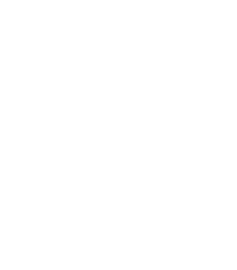

In [12]:
probas[probas > 0.5] = 0
probas[probas <= 0.5] = 255
PIL_image2 = Image.fromarray(np.uint8(probas)).convert('L')
PIL_image2